In [1]:
# base libraries
import copy
import gc
import multiprocessing
from multiprocessing import Pool
import os
from pathlib import Path
import sys
import time

# installed libraries
import cv2
import imageio
import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import scipy
import scipy.signal
import sklearn as sk
import sklearn.decomposition
import skimage.draw
import torchinterp1d
from tqdm import tqdm

sys.path.append('/n/groups/datta/akshay/bmi/')
sys.path.append('/n/groups/datta/akshay/bmi/Cascade')
import cascade2p
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

# my libraries
from basic_neural_processing_modules import *

	YAML reader installed (version 0.17.20).


Using TensorFlow backend.
2022-02-02 14:36:06.924496: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akj290/.conda/envs/bmi_idap/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-02 14:36:06.924528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


	Keras installed (version 2.3.1).
	Tensorflow installed (version 2.3.0).


/home/akj290/.conda/envs/bmi_idap/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
## == IMPORT DATA ==
dir_s2p = Path('/n/groups/datta/akshay/bmi/data/mouse2_6/20210409/baseline/suite2p/plane0')

F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]

In [3]:
# Cascade

channelOffset_correction = 150
percentile_baseline = 10
dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F + channelOffset_correction,
                                                                 Fneu=Fneu + channelOffset_correction,
                                                                 neuropil_fraction=0.7,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                             kernel=math_functions.gaussian(np.arange(-15,15), 0, sig=50/30, plot_pref=False)[0],
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True)

Calculated dFoF. Total elapsed time: 26.95 seconds
ThreadPool elapsed time : 2.93 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 6.24 seconds


In [4]:
# spike_prob = np.concatenate([cascade.predict(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel',
#                                              traces=batch, 
#                                              model_folder='/n/data1/hms/neurobio/sabatini/rich/github_repos/Cascade/Pretrained_models', 
#                                              padding=0) for batch in indexing.make_batches(dFoF_smooth, num_batches=500)], axis=0)

# np.save(dir_s2p / 'spike_prob.npy', np.single(spike_prob))

In [ ]:
spike_probs = []
with tqdm(total=200) as pbar:
    for batch in indexing.make_batches(dFoF_smooth, num_batches=200):
        spike_prob = cascade.predict(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel',
                                                 traces=batch, 
                                                 model_folder='/n/data1/hms/neurobio/sabatini/rich/github_repos/Cascade/Pretrained_models', 
                                                 padding=0)
        spike_probs.append(spike_prob)
        pbar.update(1)

spike_prob_array = np.concatenate(spike_probs, axis=0)

np.save(dir_s2p / 'spike_prob.npy', np.single(spike_prob_array))

  0%|          | 0/200 [00:00<?, ?it/s]


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 25 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.45, 0.09

Predictions for noise level 2:
	... ensemble 0
330/330 [==============================] - 10s 31ms/step
	... ensemble 1
330/330 [==============================] - 10s 31ms/step
	... ensemble 2
330/330 [==============================] - 10s 31ms/step
	... ensemble 3
330/330 [==============================] - 10s 31ms/step
	... ensemble 4
330/330 [==============================] - 10s 31ms/step


  0%|          | 1/200 [01:08<3:47:38, 68.63s/it]


Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level
Done

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 25 neurons and 108000 frames.
Noise levels (mean, std; in standard units): 0.45, 0.1

Predictions for noise level 2:
	... ensemble 0
330/330 [==============================] - 10s 31ms/step
	... ensemble 1
330/330 [==============================] - 10s 31ms/step
	... ensemble 2
330/330 [=======

In [5]:
# Load Spike Probs
spike_prob = np.load(dir_s2p / 'spike_prob.npy')

In [6]:
spike_prob.shape

(4898, 108000)

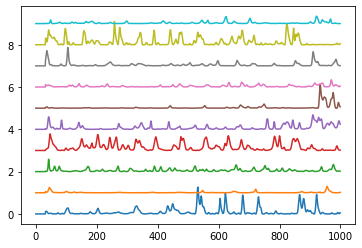

In [11]:
plt.plot(spike_prob[:10,:1000].T+np.arange(0,10))
plt.show()

In [14]:
pca = sklearn.decomposition.PCA()
spike_pcs = pca.fit_transform(spike_prob.T)

(4898, 4898)